In [132]:
import numpy as np
import math
import xgboost as xgb
import pandas as pd
import random as rd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from xgboost import plot_importance
from datetime import datetime
%matplotlib inline

import random as rd
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping

In [133]:
# load data
train = pd.read_csv("./train.csv", index_col=0)
test = pd.read_csv("./test.csv", index_col=0).reset_index(drop=True)
submission = pd.read_csv("./sample_submission.csv")

In [134]:
train['u-g'] = train['u'] - train['g']
train['g-r'] = train['g'] - train['r']
train['r-i'] = train['r'] - train['i']
train['i-z'] = train['i'] - train['z']
train['dered_u-g'] = train['dered_u'] - train['dered_g']
train['dered_g-r'] = train['dered_g'] - train['dered_r']
train['dered_r-i'] = train['dered_r'] - train['dered_i']
train['dered_i-z'] = train['dered_i'] - train['dered_z']

test['u-g'] = test['u'] - test['g']
test['g-r'] = test['g'] - test['r']
test['r-i'] = test['r'] - test['i']
test['i-z'] = test['i'] - test['z']
test['dered_u-g'] = test['dered_u'] - test['dered_g']
test['dered_g-r'] = test['dered_g'] - test['dered_r']
test['dered_r-i'] = test['dered_r'] - test['dered_i']
test['dered_i-z'] = test['dered_i'] - test['dered_z']

In [135]:
train['r_u-g'] = train['redshift'] * train['u-g']
train['r_g-r'] = train['redshift'] * train['g-r']
train['r_r-i'] = train['redshift'] * train['r-i']
train['r_i-z'] = train['redshift'] * train['i-z']
train['r_dered_u-g'] = train['redshift'] * train['dered_u-g']
train['r_dered_g-r'] = train['redshift'] * train['dered_g-r']
train['r_dered_r-i'] = train['redshift'] * train['dered_r-i']
train['r_dered_i-z'] = train['redshift'] * train['dered_i-z']

test['r_u-g'] = test['redshift'] * test['u-g']
test['r_g-r'] = test['redshift'] * test['g-r']
test['r_r-i'] = test['redshift'] * test['r-i']
test['r_i-z'] = test['redshift'] * test['i-z']
test['r_dered_u-g'] = test['redshift'] * test['dered_u-g']
test['r_dered_g-r'] = test['redshift'] * test['dered_g-r']
test['r_dered_r-i'] = test['redshift'] * test['dered_r-i']
test['r_dered_i-z'] = test['redshift'] * test['dered_i-z']

In [136]:
# zip 함수를 이용하여 각 Magnitude별 max, min, max-min, std, sum을 구한다.
ugriz = ['u', 'g', 'r', 'i', 'z']

for a, b in zip(ugriz, [ugriz, ugriz, ugriz, ugriz, ugriz]):
    train[f'{a}_max'] = train[b].max(axis=1)
    test[f'{a}_max'] = test[b].max(axis=1)
    
    train[f'{a}_min'] = train[b].min(axis=1)
    test[f'{a}_min'] = test[b].min(axis=1)
    
    train[f'{a}_diff'] = train[f'{a}_max'] - train[f'{a}_min']
    test[f'{a}_diff'] = test[f'{a}_max'] - test[f'{a}_min']
    
    train[f'{a}_sum'] = train[b].sum(axis=1)
    test[f'{a}_sum'] = test[b].sum(axis=1)

In [137]:
dered_ugriz = ['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']

for a, b in zip(dered_ugriz, [dered_ugriz, dered_ugriz, dered_ugriz, dered_ugriz, dered_ugriz]):
    train[f'{a}_max'] = train[b].max(axis=1)
    test[f'{a}_max'] = test[b].max(axis=1)
    
    train[f'{a}_min'] = train[b].min(axis=1)
    test[f'{a}_min'] = test[b].min(axis=1)
    
    train[f'{a}_diff'] = train[f'{a}_max'] - train[f'{a}_min']
    test[f'{a}_diff'] = test[f'{a}_max'] - test[f'{a}_min']
    
    train[f'{a}_sum'] = train[b].sum(axis=1)
    test[f'{a}_sum'] = test[b].sum(axis=1)

In [138]:
# https://classic.sdss.org/education/kron_ARCS.pdf
distance_train = []
for rs in train['redshift']:
    if rs > 0:
        distance_train.append((rs / (1+rs)) * 13.5 * 10**9)
    else:
        distance_train.append((abs(rs-1) / abs(rs)) * 13.5 * 10**9)

train['distance'] = distance_train

In [139]:
highest_train = []
for u, g, r, i, z in zip(train['dered_u'], train['dered_g'], train['dered_r'], train['dered_i'], train['dered_z']):
    if max([u, g, r, i, z]) == u:
        highest_train.append(u)
    elif max([u, g, r, i, z]) == g:
        highest_train.append(g)
    elif max([u, g, r, i, z]) == r:
        highest_train.append(r)
    elif max([u, g, r, i, z]) == i:
        highest_train.append(i)
    elif max([u, g, r, i, z]) == z:
        highest_train.append(z)
train['highest'] = highest_train
train['M'] = train['highest'] - 5*(np.log(train['distance']) - 1)

In [140]:
# https://classic.sdss.org/education/kron_ARCS.pdf
distance_test = []
for rs in test['redshift']:
    if rs > 0:
        distance_test.append((rs / (1+rs)) * 13.5 * 10**9)
    else:
        distance_test.append((abs(rs-1) / abs(rs)) * 13.5 * 10**9)

test['distance'] = distance_test

In [141]:
highest_test = []
for u, g, r, i, z in zip(test['dered_u'], test['dered_g'], test['dered_r'], test['dered_i'], test['dered_z']):
    if max([u, g, r, i, z]) == u:
        highest_test.append(u)
    elif max([u, g, r, i, z]) == g:
        highest_test.append(g)
    elif max([u, g, r, i, z]) == r:
        highest_test.append(r)
    elif max([u, g, r, i, z]) == i:
        highest_test.append(i)
    elif max([u, g, r, i, z]) == z:
        highest_test.append(z)
test['highest'] = highest_test
test['M'] = test['highest'] - 5*(np.log(test['distance']) - 1)

In [142]:
# n값 처리
train['nO-nD'] = train['nObserve'] - train['nDetect']
test['nO-nD'] = test['nObserve'] - test['nDetect']

In [143]:
# 단순 나눗셈
train['u/dered_u'] = train['u'] / train['dered_u'] - 1
train['g/dered_g'] = train['g'] / train['dered_g'] - 1
train['r/dered_r'] = train['r'] / train['dered_r'] - 1
train['i/dered_i'] = train['i'] / train['dered_i'] - 1
train['z/dered_z'] = train['z'] / train['dered_z'] - 1

test['u/dered_u'] = test['u'] / test['dered_u'] - 1
test['g/dered_g'] = test['g'] / test['dered_g'] - 1
test['r/dered_r'] = test['r'] / test['dered_r'] - 1
test['i/dered_i'] = test['i'] / test['dered_i'] - 1
test['z/dered_z'] = test['z'] / test['dered_z'] - 1

In [144]:
train['M_u'] = train['u'] - 5*(np.log(train['distance']) - 1)
train['M_g'] = train['g'] - 5*(np.log(train['distance']) - 1)
train['M_r'] = train['r'] - 5*(np.log(train['distance']) - 1)
train['M_i'] = train['i'] - 5*(np.log(train['distance']) - 1)
train['M_z'] = train['z'] - 5*(np.log(train['distance']) - 1)
train['M_dered_u'] = train['dered_u'] - 5*(np.log(train['distance']) - 1)
train['M_dered_g'] = train['dered_g'] - 5*(np.log(train['distance']) - 1)
train['M_dered_r'] = train['dered_r'] - 5*(np.log(train['distance']) - 1)
train['M_dered_i'] = train['dered_i'] - 5*(np.log(train['distance']) - 1)
train['M_dered_z'] = train['dered_z'] - 5*(np.log(train['distance']) - 1)

test['M_u'] = test['u'] - 5*(np.log(test['distance']) - 1)
test['M_g'] = test['g'] - 5*(np.log(test['distance']) - 1)
test['M_r'] = test['r'] - 5*(np.log(test['distance']) - 1)
test['M_i'] = test['i'] - 5*(np.log(test['distance']) - 1)
test['M_z'] = test['z'] - 5*(np.log(test['distance']) - 1)
test['M_dered_u'] = test['dered_u'] - 5*(np.log(test['distance']) - 1)
test['M_dered_g'] = test['dered_g'] - 5*(np.log(test['distance']) - 1)
test['M_dered_r'] = test['dered_r'] - 5*(np.log(test['distance']) - 1)
test['M_dered_i'] = test['dered_i'] - 5*(np.log(test['distance']) - 1)
test['M_dered_z'] = test['dered_z'] - 5*(np.log(test['distance']) - 1)

In [145]:
X = train[['u', 'g', 'r', 'i', 'z',
           'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',
           'airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z',
           'u-g', 'g-r', 'r-i', 'i-z',
           'dered_u-g', 'dered_g-r', 'dered_r-i', 'dered_i-z']]

T = test[['u', 'g', 'r', 'i', 'z',
           'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',
           'airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z',
           'u-g', 'g-r', 'r-i', 'i-z',
           'dered_u-g', 'dered_g-r', 'dered_r-i', 'dered_i-z']]

In [146]:
# scale features
scaler = RobustScaler()
scaled_train = scaler.fit_transform(X)
scaled_train = pd.DataFrame(data=scaled_train, columns=X.columns)
scaled_test = scaler.transform(T)
scaled_test = pd.DataFrame(data=scaled_test, columns=T.columns)

In [147]:
ugriz_train = np.array(scaled_train[['u', 'g', 'r', 'i', 'z']]).reshape(scaled_train.shape[0], 5, 1)
dered_ugriz_train = np.array(scaled_train[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']]).reshape(scaled_train.shape[0], 5, 1)
color_train = np.array(scaled_train[['u-g', 'g-r', 'r-i', 'i-z']]).reshape(scaled_train.shape[0], 4, 1)
dered_color_train = np.array(scaled_train[['dered_u-g', 'dered_g-r', 'dered_r-i', 'dered_i-z']]).reshape(scaled_train.shape[0], 4, 1)

ugriz_test = np.array(scaled_test[['u', 'g', 'r', 'i', 'z']]).reshape(scaled_test.shape[0], 5, 1)
dered_ugriz_test = np.array(scaled_test[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']]).reshape(scaled_test.shape[0], 5, 1)
color_test = np.array(scaled_test[['u-g', 'g-r', 'r-i', 'i-z']]).reshape(scaled_test.shape[0], 4, 1)
dered_color_test = np.array(scaled_test[['dered_u-g', 'dered_g-r', 'dered_r-i', 'dered_i-z']]).reshape(scaled_test.shape[0], 4, 1)

labels = to_categorical(train['class'], num_classes=3)

In [148]:
def rnn(X, inputshape, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
    
    model = Sequential()
    model.add(LSTM(8, input_shape=(inputshape, 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    epochs = 5
    batch_size = 16

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    score,acc = model.evaluate(X_val, y_val, verbose = 2, batch_size = batch_size)
    print("score: %.3f" % (score))
    print("acc: %.3f" % (acc))
    
    return model

In [149]:
ugriz_model = rnn(ugriz_train, 5, labels)

Epoch 1/5
14400/14400 [==============================] - 49s 3ms/step - loss: 0.7364 - accuracy: 0.6929 - val_loss: 0.6463 - val_accuracy: 0.7373
Epoch 2/5
14400/14400 [==============================] - 48s 3ms/step - loss: 0.6859 - accuracy: 0.7154 - val_loss: 0.6308 - val_accuracy: 0.7423
Epoch 3/5
14400/14400 [==============================] - 49s 3ms/step - loss: 0.6705 - accuracy: 0.7220 - val_loss: 0.6249 - val_accuracy: 0.7361
Epoch 4/5
14400/14400 [==============================] - 48s 3ms/step - loss: 0.6606 - accuracy: 0.7259 - val_loss: 0.6040 - val_accuracy: 0.7494
Epoch 5/5
14400/14400 [==============================] - 48s 3ms/step - loss: 0.6543 - accuracy: 0.7282 - val_loss: 0.5975 - val_accuracy: 0.7527
4000/4000 - 4s - loss: 0.5983 - accuracy: 0.7526
score: 0.598
acc: 0.753


In [150]:
pred = ugriz_model.predict(ugriz_train)
ugriz_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
train['rnn_ugriz'] = ugriz_recovery

In [151]:
pred = ugriz_model.predict(ugriz_test)
ugriz_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
test['rnn_ugriz'] = ugriz_recovery

In [152]:
dered_ugriz_model = rnn(dered_ugriz_train, 5, labels)

Epoch 1/5
14400/14400 [==============================] - 50s 3ms/step - loss: 0.7320 - accuracy: 0.6929 - val_loss: 0.6268 - val_accuracy: 0.7393
Epoch 2/5
14400/14400 [==============================] - 44s 3ms/step - loss: 0.6746 - accuracy: 0.7197 - val_loss: 0.6054 - val_accuracy: 0.7555
Epoch 3/5
14400/14400 [==============================] - 45s 3ms/step - loss: 0.6600 - accuracy: 0.7283 - val_loss: 0.6060 - val_accuracy: 0.7542
Epoch 4/5
14400/14400 [==============================] - 44s 3ms/step - loss: 0.6515 - accuracy: 0.7328 - val_loss: 0.6070 - val_accuracy: 0.7531
Epoch 5/5
14400/14400 [==============================] - 44s 3ms/step - loss: 0.6481 - accuracy: 0.7358 - val_loss: 0.5838 - val_accuracy: 0.7700
4000/4000 - 4s - loss: 0.5879 - accuracy: 0.7714
score: 0.588
acc: 0.771


In [153]:
pred = dered_ugriz_model.predict(dered_ugriz_train)
ugriz_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
train['rnn_dered_ugriz'] = ugriz_recovery

In [154]:
pred = dered_ugriz_model.predict(dered_ugriz_test)
ugriz_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
test['rnn_dered_ugriz'] = ugriz_recovery

In [155]:
color_model = rnn(color_train, 4, labels)

Epoch 1/5
14400/14400 [==============================] - 41s 3ms/step - loss: 0.5374 - accuracy: 0.7904 - val_loss: 0.4086 - val_accuracy: 0.8492
Epoch 2/5
14400/14400 [==============================] - 40s 3ms/step - loss: 0.4647 - accuracy: 0.8219 - val_loss: 0.3793 - val_accuracy: 0.8605
Epoch 3/5
14400/14400 [==============================] - 43s 3ms/step - loss: 0.4420 - accuracy: 0.8321 - val_loss: 0.3703 - val_accuracy: 0.8611
Epoch 4/5
14400/14400 [==============================] - 40s 3ms/step - loss: 0.4340 - accuracy: 0.8358 - val_loss: 0.3686 - val_accuracy: 0.8621
Epoch 5/5
14400/14400 [==============================] - 40s 3ms/step - loss: 0.4289 - accuracy: 0.8370 - val_loss: 0.3583 - val_accuracy: 0.8661
4000/4000 - 4s - loss: 0.3651 - accuracy: 0.8647
score: 0.365
acc: 0.865


In [156]:
pred = color_model.predict(color_train)
color_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
train['rnn_color'] = color_recovery

In [157]:
pred = color_model.predict(color_test)
color_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
test['rnn_color'] = color_recovery

In [158]:
dered_color_model = rnn(dered_color_train, 4, labels)

Epoch 1/5
14400/14400 [==============================] - 41s 3ms/step - loss: 0.5067 - accuracy: 0.8045 - val_loss: 0.3713 - val_accuracy: 0.8628
Epoch 2/5
14400/14400 [==============================] - 41s 3ms/step - loss: 0.4371 - accuracy: 0.8342 - val_loss: 0.3538 - val_accuracy: 0.8693
Epoch 3/5
14400/14400 [==============================] - 41s 3ms/step - loss: 0.4184 - accuracy: 0.8418 - val_loss: 0.3404 - val_accuracy: 0.8758
Epoch 4/5
14400/14400 [==============================] - 41s 3ms/step - loss: 0.4089 - accuracy: 0.8457 - val_loss: 0.3412 - val_accuracy: 0.8735
Epoch 5/5
14400/14400 [==============================] - 44s 3ms/step - loss: 0.4038 - accuracy: 0.8476 - val_loss: 0.3310 - val_accuracy: 0.8786
4000/4000 - 4s - loss: 0.3379 - accuracy: 0.8759
score: 0.338
acc: 0.876


In [159]:
pred = dered_color_model.predict(dered_color_train)
color_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
train['rnn_dered_color'] = color_recovery

In [160]:
pred = dered_color_model.predict(dered_color_test)
color_recovery = np.argmax(pred, axis=1).reshape(-1, 1)
test['rnn_dered_color'] = color_recovery

In [161]:
bad_feature = ['g_max', 'g_min', 'g_diff', 'g_sum', 'r_max', 'r_min', 'r_diff', 'r_sum',
               'i_max', 'i_min', 'i_diff', 'i_sum', 'z_max', 'z_min', 'z_diff', 'z_sum',
               'dered_g_max', 'dered_g_min', 'dered_g_diff', 'dered_g_sum',
               'dered_r_max', 'dered_r_min', 'dered_r_diff', 'dered_r_sum',
               'dered_i_max', 'dered_i_min', 'dered_i_diff', 'dered_i_sum',
               'dered_z_max', 'dered_z_min', 'dered_z_diff', 'dered_z_sum',
               'class']

In [162]:
useful_columns = [c for c in train.columns if c not in bad_feature]

In [163]:
X = train[useful_columns]
Y = train['class']

In [164]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=seed)
eval_set = [(X_val, y_val)]

In [165]:
start_time = datetime.now()

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    booster='gbtree',
    max_depth=12,
    learning_rate=0.1,
    n_estimators=1000,
    scale_pos_weight=1.2,
    eval_metric='merror',
    eval_set=eval_set,
    early_stopping_rounds=20
)

model.fit(X_train, y_train)

end_time = datetime.now() 
print("\nelapsed time = ", end_time - start_time)


elapsed time =  2:56:51.065699


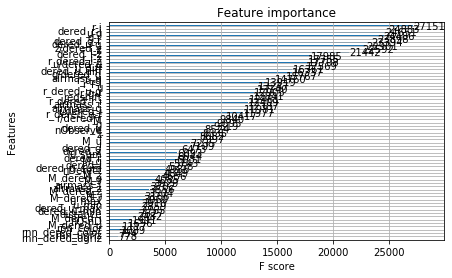

In [166]:
plot_importance(model)

In [167]:
model_pred = model.predict(X_val)
accuracy_score(y_val, model_pred)

0.936125

In [168]:
pred = model.predict(test[useful_columns])
submission['class'] = pred
submission.to_csv("submission_try.csv",index=False, encoding='utf-8-sig')